<a href="https://colab.research.google.com/github/xli2522/GW-SignalGen/blob/main/GW_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  
#  Generating Gravitational Wave Signals with Noise 
#####(for GW Classifier Training) 
##### © Xiyuan Li 2021, Department of Physics and Astronomy, Western University (UWO), London, Ontario, Canada
##### Resources: 
[PyCBC](http://github.com/ligo-cbc/pycbc) + additional PyCBC [examples](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and module level documentation are [here](http://pycbc.org/pycbc/latest/html/py-modindex.html).

##### Code *Reference*:
[gw-odw/odw-2020](http://github.com/gw-odw/odw-2020)

In [2]:
# -- Uncomment following line if running in Google Colab
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'

     |████████████████████████████████| 3.1MB 3.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 28.5MB 91kB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 890kB 31.7MB/s 
     |████████████████████████████████| 1.6MB 43.6MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 3.2MB 40.3MB/s 


In [8]:
# Initialization
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab
import numpy as np

## 1 Generating GW Waveforms
### 1.1 Generating GW Waveform using SEOBNRv4
##### [PyCBC.waveform.getwaveform Doc](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#module-pycbc.waveform.waveform)
###### Unused parameters include the spin, tidal deformability, monopole, and more.

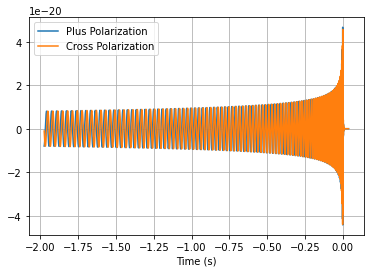

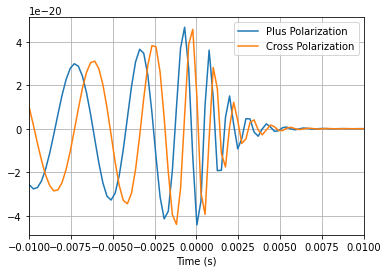

<class 'pycbc.types.timeseries.TimeSeries'>
0


In [20]:
# Generating one example waveform 
# The output of this function are the "plus" and "cross" polarizations of the gravitational-wave signal 
# as viewed from the line of sight at a given source inclination (assumed face-on if not provided)
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30,
                         distance=5)

pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time#
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

# verify container type and data extraction
print(type(hc))
testing_container = np.zeros(2, dtype=object)
print(testing_container[0])
testing_container[0], testing_container[1] = hp, hc
print(testing_container)

### 1.2 Generating N GW Waveform using SEOBNRv4
#### Binary Mass Ratio Range
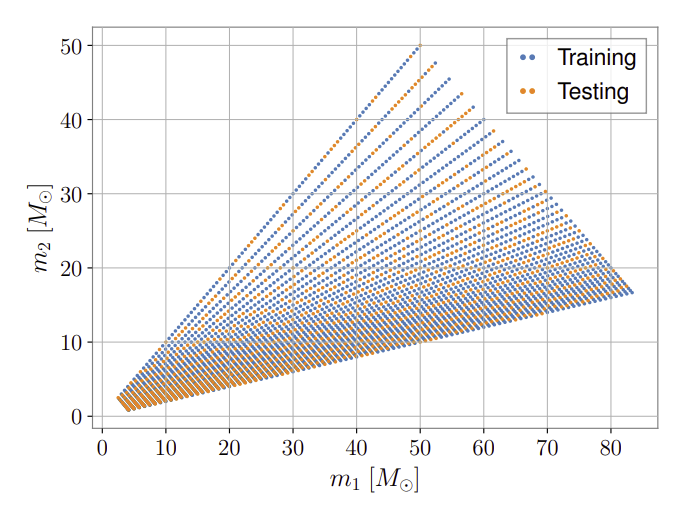

In [ ]:
# Generate a set of N parameter inputs

